# Image Segmentation using Unet example

In this notebook, we will build and train our own U-Net image segmentation architecture, in order to segment satellite images.

We will use the DroneDeploy Segmentation Dataset from https://github.com/dronedeploy/dd-ml-segmentation-benchmark of aerial photographs taken by drones, and segmentation labels for each scene. See that link for more information on the dataset.

We have already made an EDA on the dataset and we will just focuse here on the model.

Importation of libraries:

In [26]:
import cv2 
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

Importatiom of label file:

In [27]:
from google.colab import files
uploaded = files.upload()

Saving label_config.json to label_config (1).json


In [28]:
DATA_FN = 'satellite_data.tar.gz'
LABEL_CONFIG_FN = 'label_config.json'

Importation of MyDrive where the dataset is:

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we have the label configuration and the colors that will be used for each label.

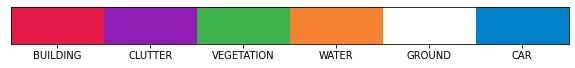

In [30]:
with open(LABEL_CONFIG_FN, 'r') as f:
  label_config = json.load(f)

N_LABELS = len(label_config)
LABEL_NAMES = sorted(label_config, key=lambda k: label_config[k]['index'])
LABEL_COLORS = np.array([label_config[n]['color'] for n in LABEL_NAMES])

plt.figure(figsize=(10, 10))
plt.imshow(LABEL_COLORS[None], aspect=0.4)
plt.xticks(range(N_LABELS), LABEL_NAMES)
plt.yticks([])
plt.show()

As is common in CV tasks, we do not want to load our entire dataset into memory at once. It will be more efficient to create generators that dynamically load image data when needed for training our model.

In [31]:
batch_size = 16
seed = 42
target_size=(128, 128)

image_datagen = ImageDataGenerator(rescale=1./255)
image_datagen_valid = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator()
mask_datagen_valid = ImageDataGenerator()

Defining the train and validation directories:

In [32]:
train_dir = """/content/drive/MyDrive/satellite_data/train/images"""
mask_train = """/content/drive/MyDrive/satellite_data/train/masks"""
valid_dir = """/content/drive/MyDrive/satellite_data/valid/images"""
mask_valid = """/content/drive/MyDrive/satellite_data/valid/masks"""

In [33]:
image_gen_train = image_datagen.flow_from_directory(directory=train_dir, 
                                         class_mode=None, batch_size=batch_size, 
                                         target_size=target_size,seed=seed)

image_gen_valid = image_datagen_valid.flow_from_directory(directory=valid_dir, 
                                         class_mode=None, batch_size=batch_size, 
                                         target_size=target_size,seed=seed)

train_gener = mask_datagen.flow_from_directory(directory=mask_train, 
                                         class_mode=None, batch_size=batch_size, 
                                         target_size=target_size,seed=seed)

valid_gener = mask_datagen_valid.flow_from_directory(directory=mask_valid, 
                                         class_mode=None, batch_size=batch_size, 
                                         target_size=target_size,seed=seed)

mask_gen_train = (x[..., 0] for x in train_gener)
mask_gen_valid = (x[..., 0] for x in valid_gener)

Found 5843 images belonging to 1 classes.
Found 1045 images belonging to 1 classes.
Found 5843 images belonging to 1 classes.
Found 1045 images belonging to 1 classes.


We now create generators for train and validation data (images and masks together).

In [34]:
train_gen = zip(image_gen_train, mask_gen_train)
valid_gen = zip(image_gen_valid, mask_gen_valid)

## Unet implementation

In [35]:
INPUT_SIZE = (128, 128, 3)
DROPOUT_P = 0.5

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

inputs=Input(INPUT_SIZE)

conv1=Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1=Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1=MaxPooling2D(pool_size=(2, 2))(conv1)

conv2=Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2=Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2=MaxPooling2D(pool_size=(2, 2))(conv2)

conv3=Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3=Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3=MaxPooling2D(pool_size=(2, 2))(conv3)

conv4=Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4=Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
out4=Dropout(DROPOUT_P)(conv4)
pool4=MaxPooling2D(pool_size=(2, 2))(out4)

conv5=Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5=Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
out5=Dropout(DROPOUT_P)(conv5)

up6=Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(out5))
merge6=concatenate([out4,up6], axis=3)
conv6=Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6=Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7=Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
merge7=concatenate([conv3,up7], axis=3)
conv7=Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7=Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8=Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
merge8=concatenate([conv2,up8], axis=3)
conv8=Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8=Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9=Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
merge9=concatenate([conv1,up9], axis=3)
conv9=Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9=Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9=Conv2D(N_LABELS, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10=Conv2D(N_LABELS, 1, activation='softmax')(conv9)

model=Model(inputs=inputs, outputs=conv10)

Information about the model:

In [36]:
print('model input shape:' ,model.input.shape)
print('model output shape:' ,model.output.shape)

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

model input shape: (None, 128, 128, 3)
model output shape: (None, 128, 128, 6)
Total params: 31,035,184.0
Trainable params: 31,035,184
Non-trainable params: 0.0


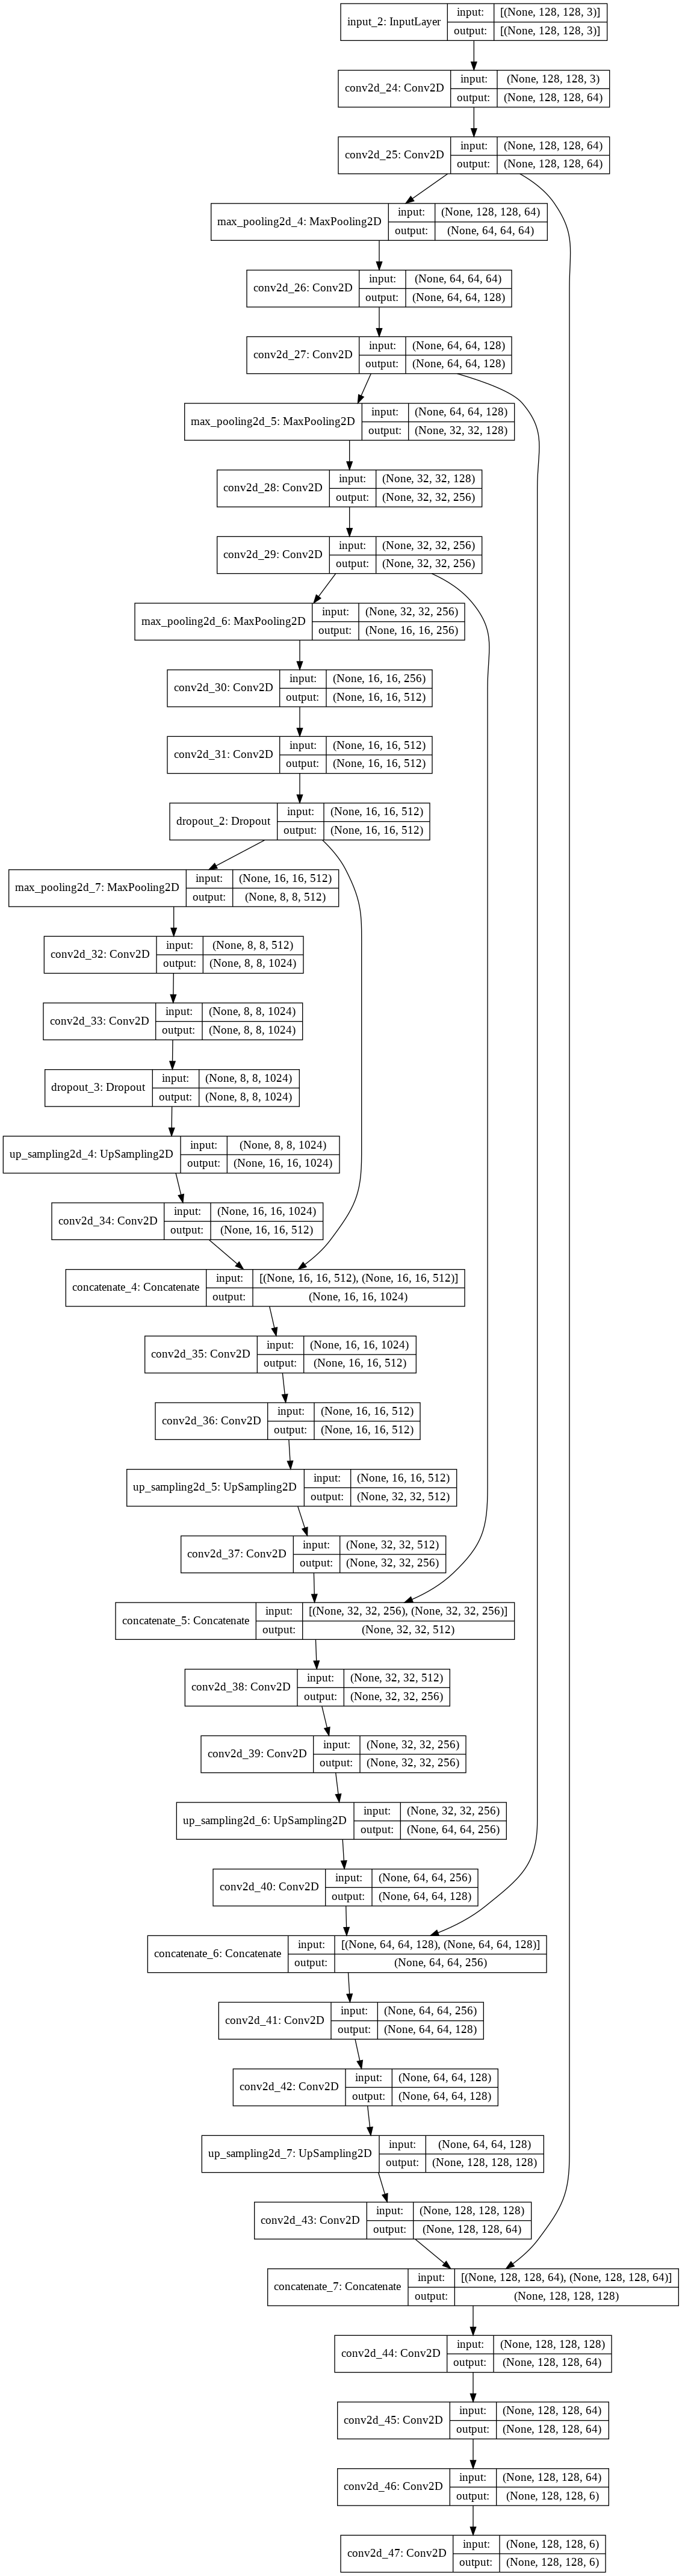

In [37]:
plot_model(model, show_shapes=True)

We compile the model with Adam optimizer (default learning rate of 1e-3), sparse categorical cross-entropy loss, and accuracy as a metric.

In [38]:
model.compile(loss='SparseCategoricalCrossentropy',optimizer='adam',metrics=["accuracy"])

In [39]:
step_train = 5843//16
step_val = 1045//16

In [40]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [42]:
model.fit(train_gen, validation_data=valid_gen, 
          steps_per_epoch=step_train, 
          validation_steps=step_val,
          callbacks=[callback],
          epochs=20)

Epoch 1/20
365/365 [==============================] - 408s 1s/step - loss: 1.0489 - accuracy: 0.7143 - val_loss: 1.0455 - val_accuracy: 0.6649
Epoch 2/20
365/365 [==============================] - 106s 287ms/step - loss: 0.8580 - accuracy: 0.7335 - val_loss: 0.9702 - val_accuracy: 0.6977
Epoch 3/20
365/365 [==============================] - 105s 288ms/step - loss: 0.7522 - accuracy: 0.7477 - val_loss: 0.8857 - val_accuracy: 0.7177
Epoch 4/20
365/365 [==============================] - 105s 287ms/step - loss: 0.7099 - accuracy: 0.7564 - val_loss: 0.8779 - val_accuracy: 0.7191
Epoch 5/20
365/365 [==============================] - 105s 288ms/step - loss: 0.6694 - accuracy: 0.7676 - val_loss: 0.8374 - val_accuracy: 0.7162
Epoch 6/20
365/365 [==============================] - 105s 288ms/step - loss: 0.6439 - accuracy: 0.7765 - val_loss: 0.9141 - val_accuracy: 0.7159
Epoch 7/20
365/365 [==============================] - 105s 287ms/step - loss: 0.6119 - accuracy: 0.7907 - val_loss: 0.8496 - va

In [43]:
from tensorflow import keras
model.save('/content/drive/MyDrive/Unet_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Unet_model/assets


Here some examples of predicted images from validation set. 

1/1 [==============================] - 0s 261ms/step


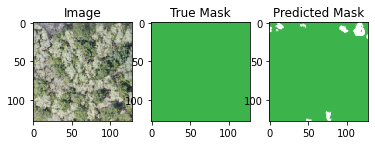

1/1 [==============================] - 0s 21ms/step


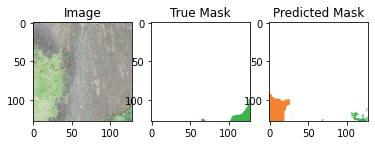

1/1 [==============================] - 0s 20ms/step


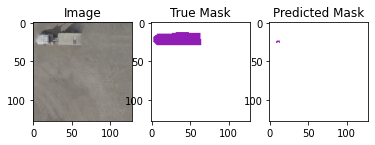

1/1 [==============================] - 0s 20ms/step


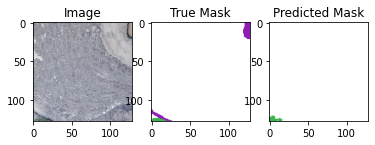

1/1 [==============================] - 0s 18ms/step


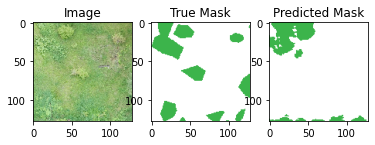

1/1 [==============================] - 0s 19ms/step


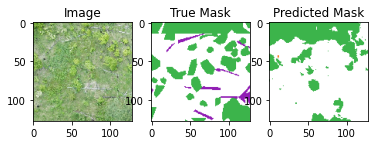

1/1 [==============================] - 0s 20ms/step


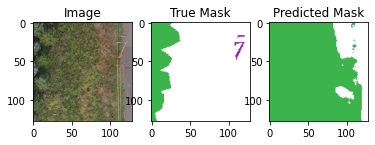

1/1 [==============================] - 0s 17ms/step


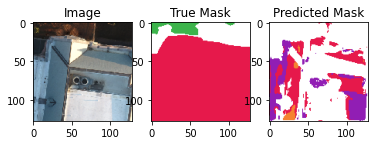

1/1 [==============================] - 0s 20ms/step


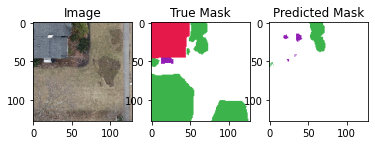

1/1 [==============================] - 0s 22ms/step


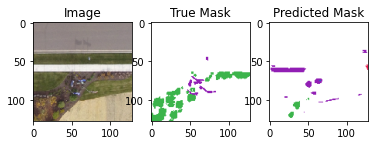

1/1 [==============================] - 0s 19ms/step


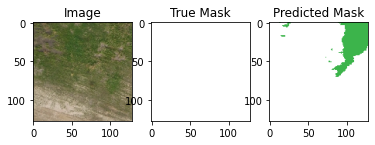

1/1 [==============================] - 0s 18ms/step


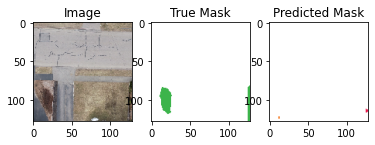

1/1 [==============================] - 0s 21ms/step


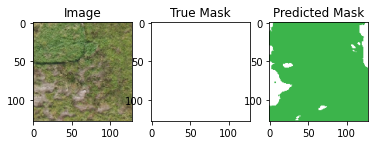

1/1 [==============================] - 0s 36ms/step


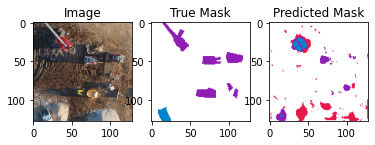

1/1 [==============================] - 0s 26ms/step


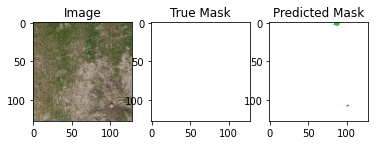

1/1 [==============================] - 0s 19ms/step


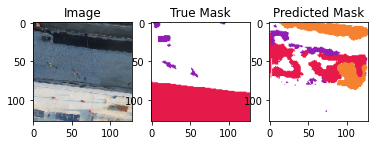

1/1 [==============================] - 0s 23ms/step


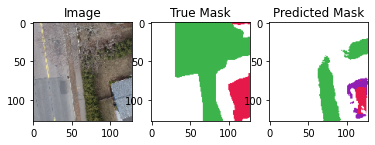

1/1 [==============================] - 0s 18ms/step


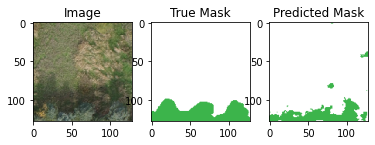

1/1 [==============================] - 0s 27ms/step


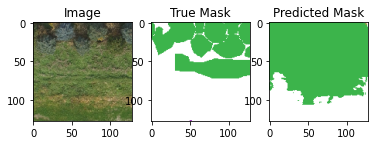

1/1 [==============================] - 0s 26ms/step


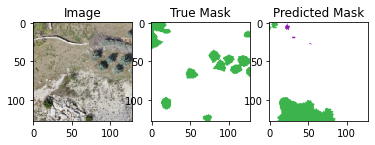

In [44]:
for _ in range(20):
    x = next(valid_gen)
    im = x[0][0]
    mas = x[1][0,...].astype(int)

    true_mas = LABEL_COLORS[mas]
    predict = model.predict(x[0], verbose=1)
    predict = predict[0,...].argmax(axis = 2)
    pred_mas = LABEL_COLORS[predict]
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(im)
    axarr[0].set_title('Image')
    axarr[1].imshow(true_mas)
    axarr[1].set_title('True Mask')
    axarr[2].imshow(pred_mas)
    axarr[2].set_title('Predicted Mask')
    plt.show()

There are of course some differences between the true and the predicted mask. The model could be improved by treating the very unbalanced dataset by assigning a greater weight to the categories less present in the labels. However, this task is more complicated when there are more than two labels. For a binary classification problem, this can be dealt with very quickly.  